# OSGD - GAN Project - Encapsulating a GAN Object

### Contents
1. Setup
2. Neural Network Class
4. Helper Functions
4. GAN Class
5. Learning a Normal Distribution
6. Other Distributions

## 1. Setup

In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable

import math 
import seaborn as sns # To plot graphs
import matplotlib.pyplot as plt
import pandas as pd

## 2. Neural Network Class

Firstly, let's make it easy to make a nn. Let's write a class which allows us to make new nn's just by specifying the layers.

In [2]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self,ModuleList):
        # Input: a torch.nn.ModuleList object, specifying nn layers
        # Output: Instanciates a nn object with the correct layers and activiation functions
        
        super(NeuralNetwork,self).__init__()
        self.layers = ModuleList # Sets network layers
        
    def forward(self,x):
        # Input: a tensor x, with size that agrees with the network
        # Output: a tensor, the network evaluated on x
        
        for l in self.layers:
            x = l(x)
        return x

## 3. Helper Functions

In [3]:
def ones_target(n):
    # Input: An integer n
    # Output: Tensor of 1's size nx1
    
    return Variable(torch.ones(n,1))
    
def zeros_target(n):
    # Input: An integer n
    # Output: Tensor of 0's size nx1
    
    return Variable(torch.zeros(n,1))

## 4. GAN Class

Next, let's take the code from the last notebook and wrap it up nicely in a GAN object

In [4]:
class GAN():
    def __init__(self,d_ModuleList,g_ModuleList):
        # Input: d_ModuleList,g_ModuleList are torch.nn.ModuleLists
        # Output: Instance of GAN class 
        
        # Instantiate the discriminator & generator
        self.discriminator = NeuralNetwork(d_ModuleList)
        self.generator = NeuralNetwork(g_ModuleList)
        
        self.dim = d_ModuleList[0][0].in_features # Number of inputs into discriminator = dimention of data
        
        # Check layers in network are of the correct sizes
        if g_ModuleList[0][0].in_features != self.dim:
            raise Exception('The input layer for the discriminator and generator need to be of the same size')
        if g_ModuleList[-1][-1].out_features != self.dim:
            raise Exception('The output layer for the discriminator and input layer of the generator need to be of the same size')
    
    def update_discriminator(self,real_data,generated_data):
        # Input: real_data (minibatch from real data set) ,generated_data (minibatch made by generator)
        # Output: discriminator's loss and mean predictions for real and generated data
        
        # Initial setup/clearing of gradients
        self.d_optimiser.zero_grad()
        loss = nn.BCELoss()
        N,M = real_data.size(0),generated_data.size(0)
        
        # Apply discriminator to data entered (in order real then fake)
        x = self.discriminator(torch.cat([real_data,generated_data]))
        
        # Create target labels (in order real then fake)
        y = torch.cat([ones_target(N),zeros_target(M)])
        
        # Calculate loss and backprop
        error = loss(x,y)
        error.backward()
        
        # Update discriminator network
        self.d_optimiser.step()
        
        # Return error and mean predictions
        return error.detach().numpy(), torch.mean(x[:N].detach()).numpy(),torch.mean(x[-M:].detach()).numpy()
        
    def update_generator(self,generated_data):
        # Input: generated_data (minibatch made by generator)
        # Output: generators' loss
        
        # Initial setup/clearing of gradients
        self.g_optimiser.zero_grad()
        loss = nn.BCELoss()
        M = generated_data.size(0)
        
        # Apply discriminator to data entered
        x = self.discriminator(generated_data)
        
        # Create target labels
        y = ones_target(M) # Want target to be 1's, opposite of disciminator's aim
        
        # Calculate loss and backprop
        error = loss(x,y)
        error.backward()
        
        # Update generator network
        self.g_optimiser.step()
        
        # Return error
        return error.detach().numpy() 
    
    def train(self,data,batch_size,n_EPOCHS,learning_rate):
        # Input: data (in a tensor) ,batch_size,n_EPOCHS,learning_rate
        # Output: prints progress info, updates discriminator and generator networks
        
        # Sets optimisers
        self.d_optimiser = optim.Adam(self.discriminator.parameters(), learning_rate)
        self.g_optimiser = optim.Adam(self.generator.parameters(), learning_rate)
        
        k = 2 # Number of steps to apply to the discriminator, In original paper this variable is assigned to 1
        j = math.ceil(data.size(0)/batch_size) # Number of loops to see all the real data
        
        for e in range(1,n_EPOCHS+1):
            for b in range(j):
                for i in range(k):
                    # Get batch of real data
                    start,end = b*batch_size,(b+1)*batch_size #Note: end may be larger than len(data)
                    real_data = data[start:end].view(-1,self.dim) # Shapes data into a collumn vector
                
                    # Get batch of fake data from generator
                    generated_data = self.generator(self.noise(real_data.size(0))).detach() # Same size as real_data, detatch so generator gradient not affected
            
                    # Optimise discriminator
                    d_error,avg_real_pred,avg_fake_pred = self.update_discriminator(real_data,generated_data)
            
            
                # Optimise generator, with new batch of generated data
                generated_data = self.generator(self.noise(batch_size)) # Need new data here as discriminator has been trained on the 'old' generated_data
                g_error = self.update_generator(generated_data)
            
            # Progress info
            if (e*100/n_EPOCHS) % 10 == 0:
                print("Training "+str(e*100/n_EPOCHS)+"% Complete:")
                print("\t Generator Loss =     "+str(g_error))
                print("\t Discriminator Loss = "+str(d_error))
            
                print("\t\t avg prediction on real data = "+str(avg_real_pred)) # Prints avg predictions on real data (discrim wants this to be 1, we want 0.5)
                print("\t\t avg prediction on fake data = "+str(avg_fake_pred)) # Prints avg predictions on fake data (discrim wants this to be 0, we want 0.5)
            
    def noise(self,n):
    # Input: An integer n, the number of samples to make
    # Output: A tensor of size nxdims of random values

        return Variable(torch.randn(n,self.dim))
    
    def generate(self,n):
        # Input: n (number of values to geneerate)
        # Output: n generated data items from the generator
        
        return self.generator(self.noise(n)).detach().numpy()

## 5. Learning a Normal Distribution

This is all well and good, but does it actually work? Let's try recreate the GAN that learned a normal distribution from the last notebook.

In [5]:
d_normal_ModuleList = nn.ModuleList([
        nn.Sequential( 
            nn.Linear(1, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ),
        nn.Sequential(
            nn.Linear(8, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ),
        nn.Sequential(
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid() # Sigmoid activation layer, so value out is in (0,1) representing a probability
        )
])

g_normal_ModuleList = nn.ModuleList([
        nn.Sequential(
            nn.Linear(1,8),
            nn.LeakyReLU(0.1)
        ),
        nn.Sequential(
            nn.Linear(8,8),
            nn.LeakyReLU(0.1)
        ),
        nn.Sequential(
            nn.Linear(8,1)
            # Note: Don't want an activiation function here, as would mess with output, or do we??
        )
])

In [6]:
normal_data = torch.randn(2500) # Some N(0,1) random numbers, used as source data
normal_gan = GAN(d_normal_ModuleList,g_normal_ModuleList)

In [7]:
normal_gan.train(normal_data,50,250,0.0002)

Training 10.0% Complete:
	 Generator Loss =     1.0185696
	 Discriminator Loss = 0.55451035
		 avg prediction on real data = 0.58164006
		 avg prediction on fake data = 0.3514047
Training 20.0% Complete:
	 Generator Loss =     0.8640204
	 Discriminator Loss = 0.5912956
		 avg prediction on real data = 0.570401
		 avg prediction on fake data = 0.41457126
Training 30.0% Complete:
	 Generator Loss =     0.6369056
	 Discriminator Loss = 0.7627184
		 avg prediction on real data = 0.49478847
		 avg prediction on fake data = 0.52650976
Training 40.0% Complete:
	 Generator Loss =     0.6859348
	 Discriminator Loss = 0.6788974
		 avg prediction on real data = 0.49848568
		 avg prediction on fake data = 0.48017898
Training 50.0% Complete:
	 Generator Loss =     0.70482093
	 Discriminator Loss = 0.7009921
		 avg prediction on real data = 0.5022176
		 avg prediction on fake data = 0.5068105
Training 60.0% Complete:
	 Generator Loss =     0.6933262
	 Discriminator Loss = 0.6958027
		 avg prediction

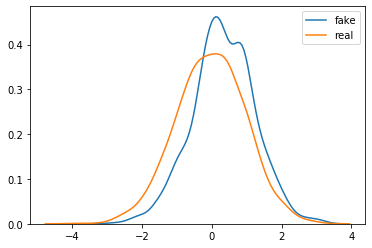

In [8]:
sns.distplot(normal_gan.generate(1000),hist=False,label='fake')
sns.distplot(normal_data,hist=False,label='real')
plt.legend();

## 6. Other Distributions

We can now make a new instance of the GAN object and train it on data from a different distribution

In [9]:
import torch.distributions as dist
exp = dist.Exponential(torch.tensor([6.0])) # Exponential distributed with rate = 6
exp_data = exp.sample([2500]) # New data set

In [10]:
d_exp_ModuleList = nn.ModuleList([
        nn.Sequential( 
            nn.Linear(1, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ),
        nn.Sequential(
            nn.Linear(8, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ),
        nn.Sequential(
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid() # Sigmoid activation layer, so value out is in (0,1) representing a probability
        )
])

g_exp_ModuleList = nn.ModuleList([
        nn.Sequential(
            nn.Linear(1,8),
            nn.LeakyReLU(0.1)
        ),
        nn.Sequential(
            nn.Linear(8,8),
            nn.LeakyReLU(0.1)
        ),
        nn.Sequential(
            nn.Linear(8,1)
            # Note: Don't want an activiation function here, as would mess with output, or do we??
        )
])
# Note: it's important we make a new module list, as the module list stores the weights and biases.
# So if we used the one from before it would copy the weights, which isn't what we want!

In [11]:
exp_gan = GAN(d_exp_ModuleList,g_exp_ModuleList) # Note this is a new instance of GAN

In [12]:
exp_gan.train(exp_data,50,350,0.0002)

Training 10.0% Complete:
	 Generator Loss =     0.6920204
	 Discriminator Loss = 0.6946043
		 avg prediction on real data = 0.49995834
		 avg prediction on fake data = 0.50113606
Training 20.0% Complete:
	 Generator Loss =     0.68802035
	 Discriminator Loss = 0.6918357
		 avg prediction on real data = 0.49965397
		 avg prediction on fake data = 0.49818954
Training 30.0% Complete:
	 Generator Loss =     0.69979227
	 Discriminator Loss = 0.6920385
		 avg prediction on real data = 0.49792847
		 avg prediction on fake data = 0.49656904
Training 40.0% Complete:
	 Generator Loss =     0.69433516
	 Discriminator Loss = 0.6904916
		 avg prediction on real data = 0.5035168
		 avg prediction on fake data = 0.5007875
Training 50.0% Complete:
	 Generator Loss =     0.6957861
	 Discriminator Loss = 0.6828303
		 avg prediction on real data = 0.50669247
		 avg prediction on fake data = 0.49580544
Training 60.0% Complete:
	 Generator Loss =     0.6926608
	 Discriminator Loss = 0.685242
		 avg predict

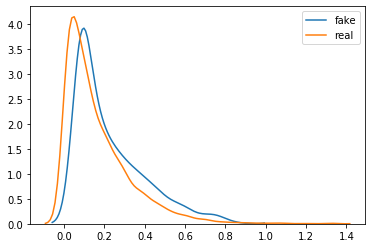

In [13]:
sns.distplot(exp_gan.generate(1000),hist=False,label='fake')
sns.distplot(exp_data,hist=False,label='real')
plt.legend();

## 7. Learning a Multivariate Normal Distribution

In [14]:
import torch.distributions as dist
multivariate_normal = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
multivariate_data = multivariate_normal.sample([5000])

In [15]:
d_multivariate_ModuleList = nn.ModuleList([
        nn.Sequential( 
            nn.Linear(2, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ),
        nn.Sequential(
            nn.Linear(8, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        ),
        nn.Sequential(
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid() # Sigmoid activation layer, so value out is in (0,1) representing a probability
        )
])

g_multivariate_ModuleList = nn.ModuleList([
        nn.Sequential(
            nn.Linear(2,8),
            nn.LeakyReLU(0.1)
        ),
        nn.Sequential(
            nn.Linear(8,8),
            nn.LeakyReLU(0.1)
        ),
        nn.Sequential(
            nn.Linear(8,2)
            # Note: Don't want an activiation function here, as would mess with output, or do we??
        )
])
# Note: The input,output for generator and input to discriminator are now 2, for 2D data!

In [16]:
multivariate_gan = GAN(d_multivariate_ModuleList,g_multivariate_ModuleList)

In [17]:
multivariate_gan.train(multivariate_data,50,350,0.0002)

Training 10.0% Complete:
	 Generator Loss =     0.6756049
	 Discriminator Loss = 0.68602806
		 avg prediction on real data = 0.5071886
		 avg prediction on fake data = 0.49785817
Training 20.0% Complete:
	 Generator Loss =     0.7049229
	 Discriminator Loss = 0.6907416
		 avg prediction on real data = 0.50689876
		 avg prediction on fake data = 0.50303954
Training 30.0% Complete:
	 Generator Loss =     0.691252
	 Discriminator Loss = 0.6912457
		 avg prediction on real data = 0.5014795
		 avg prediction on fake data = 0.4994437
Training 40.0% Complete:
	 Generator Loss =     0.6917526
	 Discriminator Loss = 0.6935563
		 avg prediction on real data = 0.5021179
		 avg prediction on fake data = 0.5023464
Training 50.0% Complete:
	 Generator Loss =     0.6966855
	 Discriminator Loss = 0.6898412
		 avg prediction on real data = 0.502408
		 avg prediction on fake data = 0.49894875
Training 60.0% Complete:
	 Generator Loss =     0.6959281
	 Discriminator Loss = 0.69219255
		 avg prediction on

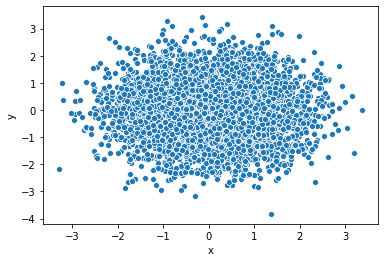

In [18]:
real_df = pd.DataFrame(multivariate_data,columns=['x','y'])
sns.scatterplot(x="x", y="y", data=real_df)

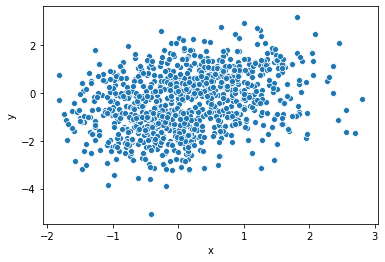

In [19]:
fake_df = pd.DataFrame(multivariate_gan.generate(1000),columns=['x','y'])
sns.scatterplot(x="x", y="y", data=fake_df)